## Test different modeling approaches

In [1]:
# =============================================================================
# DATASET CONFIGURATION - Easy switching between dataset subsets
# =============================================================================

import sys
from pathlib import Path
sys.path.insert(0, str(Path('../').resolve()))

from dataset_config import (
    DEFAULT_CONFIG, get_dataset_config, get_dataset_path, get_config_summary,
    use_full_dataset, use_english_only, use_major_studios, use_english_major
)

# =============================================================================
# CHOOSE YOUR DATASET SCOPE - Uncomment one line to switch
# =============================================================================

# CURRENT_CONFIG = use_full_dataset()                    # All studios, all languages (2010-2026)
# CURRENT_CONFIG = use_english_only(2010)                # English only (2010-2026)
CURRENT_CONFIG = use_english_only(2015)                # English only (2015-2026)
# CURRENT_CONFIG = use_major_studios(2010)               # Major studios only (2010-2026)
# CURRENT_CONFIG = use_major_studios(2015)               # Major studios only (2015-2026)
# CURRENT_CONFIG = use_english_major(2010)               # English + Major studios (2010-2026)
# CURRENT_CONFIG = use_english_major(2015)               # English + Major studios (2015-2026)

# CURRENT_CONFIG = DEFAULT_CONFIG  # Use default (full dataset)

print("🎯 DATASET CONFIGURATION:")
print("=" * 50)
print(get_config_summary(CURRENT_CONFIG))
print("\n💡 To change scope, uncomment one of the CURRENT_CONFIG lines above and re-run this cell")

🎯 DATASET CONFIGURATION:
📊 Dataset Configuration: English Only
   Description: English movies only
   Year range: 2015-2026
   Training file: dataset_domestic_processed_english_2015_2026.csv
   Full file: dataset_domestic_processed_english_2015_2026.csv


💡 To change scope, uncomment one of the CURRENT_CONFIG lines above and re-run this cell


In [2]:
import json

# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys

_NOTEBOOK_DIR = Path().resolve()
_candidate_paths = [
    _NOTEBOOK_DIR,
    _NOTEBOOK_DIR / 'code',
    _NOTEBOOK_DIR.parent,
    _NOTEBOOK_DIR.parent / 'code',
]

for _candidate in _candidate_paths:
    if (_candidate / 'model_utils.py').exists():
        sys.path.insert(0, str(_candidate))
        break

from model_utils import (
    DEFAULT_EXCLUDE_COLS,
    prepare_features,
    evaluate_model,
    create_sample_weights,
    log_results_to_mlflow,
    calculate_top_k_overlap,
    compute_ranking_metrics,
)

# MLflow experiment setup
try:
    import mlflow
    MLFLOW_AVAILABLE = True
except ImportError:
    mlflow = None
    MLFLOW_AVAILABLE = False
    print("⚠️  MLflow not installed; skipping run tracking.")
else:
    MLFLOW_TRACKING_DIR = (_NOTEBOOK_DIR.parent / 'mlruns').resolve()
    mlflow.set_tracking_uri(f"file://{MLFLOW_TRACKING_DIR}")
    mlflow.set_experiment("box_office_modeling")

DEFAULT_MLFLOW_TAGS = {
    "project": "box_office",
    "notebook": "4_try_different_modeling_approaches",
}

def build_validation_snapshot(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    columns = []
    for col in ("title", "release_year"):
        if col in df.columns:
            columns.append(col)
    if target_col in df.columns and target_col not in columns:
        columns.append(target_col)
    if not columns:
        return df.copy()
    return df[columns].copy()

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
# Load dataset using configuration system
def load_dataset(training=False):
    """Load the configured dataset subset."""
    import pandas as pd
    from movie_lists import normalize_domestic_titles

    dataset_path = get_dataset_path(training=training, config=CURRENT_CONFIG)
    dataset_config = get_dataset_config(CURRENT_CONFIG)

    print(f"📁 Loading dataset: {dataset_path}")
    
    # Load data
    df = pd.read_csv(dataset_path)

    # Apply additional filtering if needed (for english_major scope)
    if dataset_config['scope'] == 'english_major':
        if 'is_major_studio' in df.columns:
            original_len = len(df)
            df = df[df['is_major_studio'] == 1].copy()
            print(f"   Filtered to major studios: {len(df):,} movies (removed {original_len - len(df):,})")

    # Normalize titles
    df = normalize_domestic_titles(df)

    print(f"   ✅ Loaded {len(df):,} movies")
    if 'release_year' in df.columns:
        print(f"   Year range: {df['release_year'].min()}-{df['release_year'].max()}")

        # Show breakdown by time period
        training_count = len(df[df['release_year'] <= 2023])
        test_2024_count = len(df[df['release_year'] == 2024])
        eval_2025_count = len(df[df['release_year'] == 2025])
        pred_2026_count = len(df[df['release_year'] == 2026])

        print(f"   Training (≤2023): {training_count:,} movies")
        if test_2024_count > 0:
            print(f"   Testing (2024): {test_2024_count:,} movies")
        if eval_2025_count > 0:
            print(f"   Evaluation (2025): {eval_2025_count:,} movies")
        if pred_2026_count > 0:
            print(f"   Prediction (2026): {pred_2026_count:,} movies")

    return df

# Load the dataset
df = load_dataset(training=True)  # Use training=True for modeling notebooks

# Extract dataset configuration info for MLflow logging
dataset_config = get_dataset_config(CURRENT_CONFIG)
DATASET_START_YEAR = dataset_config['year_start']
print(f"\n📊 Dataset configuration for MLflow:")
print(f"   Start year: {DATASET_START_YEAR}")
print(f"   Scope: {dataset_config['scope']}")

print(f"Dataset loaded: {df.shape[0]} movies, {df.shape[1]} features")
print(f"Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}")
print(f"Average revenue: ${df['revenue_domestic'].mean():,.0f}")

# Display basic info
print(f"\nRevenue distribution by year:")
yearly_stats = df.groupby('release_year')['revenue_domestic'].agg(['count', 'mean', 'median', 'max']).round(0)
print(yearly_stats)

📁 Loading dataset: ../data/dataset_domestic_processed_english_2015_2026.csv
No title corrections needed
   ✅ Loaded 1,307 movies
   Year range: 2015-2026
   Training (≤2023): 1,003 movies
   Testing (2024): 145 movies
   Evaluation (2025): 114 movies
   Prediction (2026): 45 movies

📊 Dataset configuration for MLflow:
   Start year: 2015
   Scope: english
Dataset loaded: 1307 movies, 100 features
Date range: 2015-2026
Revenue range: $526,074 - $936,662,225
Average revenue: $66,838,299

Revenue distribution by year:
              count        mean      median          max
release_year                                            
2015            136  75285031.0  34559332.0  936662225.0
2016            132  73567446.0  40555070.0  533539991.0
2017            132  77017075.0  35321590.0  620181382.0
2018            137  75950480.0  36343858.0  700426566.0
2019            125  83568142.0  39014193.0  858373000.0
2020             52  23205224.0   8822543.0  206305244.0
2021             85  50

In [4]:
# IMPORTANT: Exclude 2024, 2025, and 2026 data from training to prevent data leakage
# 2024 = test set (for model evaluation)
# 2025 = evaluation set (for additional validation)
# 2026 = prediction set (for forecasting)
original_count = len(df)
df_training = df[df['release_year'] <= 2023].copy()
df_2024 = df[df['release_year'] == 2024].copy()
df_2025 = df[df['release_year'] == 2025].copy()
df_2026 = df[df['release_year'] == 2026].copy()

print(f"🚨 DATA LEAKAGE PREVENTION:")
print(f"   Original dataset: {original_count:,} movies")
print(f"   Training data (2010-2023): {len(df_training):,} movies") 
print(f"   2024 test data: {len(df_2024):,} movies (EXCLUDED from training)")
print(f"   2025 evaluation data: {len(df_2025):,} movies (EXCLUDED from training)")
print(f"   2026 prediction data: {len(df_2026):,} movies (EXCLUDED from training)")
print(f"   ✅ Using training period data only for model development")

# Use training data only for the rest of the notebook
df = df_training

print(f"\n📊 Training dataset summary:")
print(f"   Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"   Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}") 
print(f"   Average revenue: ${df['revenue_domestic'].mean():,.0f}")
print(f"   Models will be tested on 2024, evaluated on 2025, and predict 2026")

🚨 DATA LEAKAGE PREVENTION:
   Original dataset: 1,307 movies
   Training data (2010-2023): 1,003 movies
   2024 test data: 145 movies (EXCLUDED from training)
   2025 evaluation data: 114 movies (EXCLUDED from training)
   2026 prediction data: 45 movies (EXCLUDED from training)
   ✅ Using training period data only for model development

📊 Training dataset summary:
   Date range: 2015-2023
   Revenue range: $531,430 - $936,662,225
   Average revenue: $71,083,115
   Models will be tested on 2024, evaluated on 2025, and predict 2026


In [5]:
# Dataset scope toggles (edit as needed)
scope_config_path = _NOTEBOOK_DIR.parent / 'data' / 'dataset_scope.json'
DEFAULT_SCOPE = {
    'filter_major_studios': False,
    'filter_english_only': False,
}
if scope_config_path.exists():
    try:
        DEFAULT_SCOPE.update(json.loads(scope_config_path.read_text()))
        print(f"Loaded dataset scope defaults from {scope_config_path.name}: {DEFAULT_SCOPE}")
    except json.JSONDecodeError:
        print('⚠️ Could not parse dataset_scope.json; using notebook defaults.')

FILTER_MAJOR_STUDIOS = DEFAULT_SCOPE['filter_major_studios']
FILTER_ENGLISH_ONLY = DEFAULT_SCOPE['filter_english_only']

# Uncomment to override defaults in this notebook run
# FILTER_MAJOR_STUDIOS = True
# FILTER_ENGLISH_ONLY = True

print('🎛️ Modeling dataset scope:')
print(f"   • FILTER_MAJOR_STUDIOS = {FILTER_MAJOR_STUDIOS}")
print(f"   • FILTER_ENGLISH_ONLY  = {FILTER_ENGLISH_ONLY}")


Loaded dataset scope defaults from dataset_scope.json: {'filter_major_studios': False, 'filter_english_only': False, 'studio_note': 'all studios', 'language_note': 'all languages', 'row_count': 1994}
🎛️ Modeling dataset scope:
   • FILTER_MAJOR_STUDIOS = False
   • FILTER_ENGLISH_ONLY  = False


In [6]:

def apply_dataset_scope(dataframe: pd.DataFrame, *, filter_major: bool = False, filter_english: bool = False, verbose: bool = True):
    df_scoped = dataframe.copy()
    notes = []

    if filter_major:
        if 'is_major_studio' in df_scoped.columns:
            before = len(df_scoped)
            df_scoped = df_scoped[df_scoped['is_major_studio'] == 1].copy()
            notes.append(f"major studios only ({len(df_scoped):,} rows, dropped {before - len(df_scoped):,})")
        else:
            if verbose:
                print('⚠️ FILTER_MAJOR_STUDIOS=True but "is_major_studio" column missing; skipping filter.')
            notes.append('major filter skipped (column missing)')
    else:
        notes.append('all studios')

    if filter_english:
        if 'is_english' in df_scoped.columns:
            before = len(df_scoped)
            df_scoped = df_scoped[df_scoped['is_english'] == 1].copy()
            notes.append(f"english-only ({len(df_scoped):,} rows, dropped {before - len(df_scoped):,})")
        elif 'original_language' in df_scoped.columns:
            before = len(df_scoped)
            df_scoped = df_scoped[df_scoped['original_language'].fillna('').str.lower() == 'en'].copy()
            notes.append(f"english-only ({len(df_scoped):,} rows, dropped {before - len(df_scoped):,})")
        else:
            if verbose:
                print('⚠️ FILTER_ENGLISH_ONLY=True but language columns missing; skipping filter.')
            notes.append('language filter skipped (column missing)')
    else:
        notes.append('all languages')

    scope = {
        'filter_major_studios': bool(filter_major),
        'filter_english_only': bool(filter_english),
        'studio_note': notes[0],
        'language_note': notes[1],
        'row_count': len(df_scoped),
    }
    if verbose:
        print('🎛️ Applied dataset scope:')
        print(f"   - Studio scope: {notes[0]}")
        print(f"   - Language scope: {notes[1]}")
        print(f"   - Rows retained: {len(df_scoped):,}")
    return df_scoped, scope


In [7]:

# Apply dataset scope and persist for downstream notebooks
df, DATA_SCOPE = apply_dataset_scope(
    df,
    filter_major=FILTER_MAJOR_STUDIOS,
    filter_english=FILTER_ENGLISH_ONLY,
    verbose=True,
)

DATA_SCOPE_PATH = _NOTEBOOK_DIR.parent / 'data' / 'dataset_scope.json'
DATA_SCOPE_PATH.write_text(json.dumps({
    'filter_major_studios': FILTER_MAJOR_STUDIOS,
    'filter_english_only': FILTER_ENGLISH_ONLY,
    'studio_note': DATA_SCOPE.get('studio_note'),
    'language_note': DATA_SCOPE.get('language_note'),
    'row_count': DATA_SCOPE.get('row_count'),
}, indent=2))
print(f"📄 Saved dataset scope details to {DATA_SCOPE_PATH}")

filtered_data_path = _NOTEBOOK_DIR.parent / 'data' / 'dataset_domestic_processed_modeling.csv'
df.to_csv(filtered_data_path, index=False)
print(f"💾 Wrote filtered modeling dataset to {filtered_data_path}")


🎛️ Applied dataset scope:
   - Studio scope: all studios
   - Language scope: all languages
   - Rows retained: 1,003
📄 Saved dataset scope details to /Users/jasmineplows/Documents/California/Projects/box_office/data/dataset_scope.json
💾 Wrote filtered modeling dataset to /Users/jasmineplows/Documents/California/Projects/box_office/data/dataset_domestic_processed_modeling.csv


In [8]:
df

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,production_countries,release_year,genres,title_normalized,domestic_revenue,rank,distributor,revenue_domestic,revenue,genre_names,production_country_codes,is_origin_usa,is_origin_uk_ie,is_origin_canada,is_origin_us_uk_ca,is_disney,is_warner_bros,is_universal,is_sony,is_paramount,is_fox,is_mgm,is_lionsgate,is_major_studio,is_english,genre_drama,genre_comedy,genre_action,genre_thriller,genre_adventure,genre_romance,genre_horror,genre_science_fiction,genre_crime,genre_family,genre_fantasy,genre_animation,genre_mystery,genre_history,genre_music,genre_war,genre_western,is_action_adventure,is_action_sci_fi,is_comedy_romance,is_family_animation,primary_genre,genre_count,release_month,release_month_name,release_season,is_summer_blockbuster,is_holiday_release,is_oscar_season,is_holiday_proximity,nearest_holiday,days_to_holiday,is_christmas_proximity,is_thanksgiving_proximity,is_independence_day_proximity,is_memorial_labor_day_proximity,has_nearby_major_release,nearby_major_releases_count,nearby_major_releases_max_revenue,days_to_nearest_major_release,competition_intensity,has_blockbuster_competition,has_immediate_competition,is_marvel,is_dc,is_star_wars,is_fast_furious,is_harry_potter,is_franchise_sequel,is_sequel,is_live_action_remake,is_adaptation,is_superhero,has_remake_indicator,is_remake_adaptation,is_ip_movie,years_since_baseline,is_pre_streaming_era,is_streaming_transition,is_pandemic_year,is_post_pandemic_era
0,False,/8BTsTfln4jlQrLXUBquXJ0ASQy9.jpg,"[12, 28, 878]",140607,en,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,10.7618,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,2015-12-18,Star Wars: The Force Awakens,False,7.256,19975,"[{'iso_3166_1': 'US', 'name': 'United States o...",2015,"[12, 28, 878]",Star Wars: The Force Awakens,936662225.0,1.0,Walt Disney Studios Motion Pictures,936662225.0,936662225.0,"Adventure,Action,Science Fiction",['US'],1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,Adventure,3,12,December,Winter,0,1,1,1,Christmas,7.0,1,0,0,0,1,7,183637894,0.0,High,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,5,1,0,0,0
1,False,/dF6FjTZzRTENfB4R17HDN20jLT2.jpg,"[28, 12, 878, 53]",135397,en,Jurassic World,Twenty-two years after the events of Jurassic ...,13.2800,/rhr4y79GpxQF9IsfJItRXVaoGs4.jpg,2015-06-12,Jurassic World,False,6.699,21012,"[{'iso_3166_1': 'US', 'name': 'United States o...",2015,"[28, 12, 878, 53]",Jurassic World,653406625.0,10.0,Universal Pictures,653406625.0,653406625.0,"Action,Adventure,Science Fiction,Thriller",['US'],1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,Action,4,6,June,Summer,1,0,0,0,NaN,NaN,0,0,0,0,1,5,356461711,7.0,High,1,1,0,0,0,0,0,1,1,0,1,0,0,1,1,5,1,0,0,0
2,False,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,15.7504,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,2015-05-01,Avengers: Age of Ultron,False,7.300,23734,"[{'iso_3166_1': 'US', 'name': 'United States o...",2015,"[28, 12, 878]",Avengers: Age of Ultron,459005868.0,29.0,Walt Disney Studios Motion Pictures,459005868.0,459005868.0,"Action,Adventure,Science Fiction",['US'],1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,Action,3,5,May,Spring,1,0,0,0,NaN,NaN,0,0,0,0,1,3,184296230,14.0,High,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,5,1,0,0,0
3,False,/jJKZaTBNenlFclQyjrnvzkRmvWE.jpg,"[16, 10751, 12, 18, 35]",150540,en,Inside Out,"When 11-year-old Riley moves to a new city, he...",17.8144,/2H1TmgdfNtsKlU9jKdeNyYL5y8T.jpg,2015-06-19,Inside Out,False,7.910,22807,"[{'iso_3166_1': 'US', 'name': 'United States o...",2015,"[16, 10751, 12, 18, 35]",Inside Out,356461711.0,71.0,Walt Disney Studios Motion Pictures,356461711.0,356461711.0,"Animation,Family,Adventure,Drama,Comedy",['US'],1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,Animation,5,6,Jun

### Define Features to Use

In [9]:
# Prepare feature matrix using shared helper

df, feature_cols, target = prepare_features(
    df,
    exclude_cols=DEFAULT_EXCLUDE_COLS,
    filter_major_only=False,
    drop_major_flag_from_features=False,
    verbose=True,
)

print(f"Target variable: {target}")
print(f"Missing values in target: {df[target].isnull().sum()}")
print(f"Total features available: {len(feature_cols)}")



🔧 Feature preparation summary:
   • Candidate features: 68
   • Excluded non-numeric columns:
     – production_countries: sample values ["[{'iso_3166_1': 'US', 'name': 'United States of America'}]", "[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]", "[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]", "[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso_3166_1': 'HK', 'name': 'Hong Kong'}, {'iso_3166_1': 'TW', 'name': 'Taiwan'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]", "[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'AU', 'name': 'Australia'}]"]
     – production_country_codes: sample values ["['US']", "['DE', 'US']", "['GB', 'US']", "['TW', 'US', 'HK', 'CA']", "['AU', 'US', 'CA']"]
   • Columns with missing values:
     – days_to_holiday: 507 nulls
Target variable: revenue_domestic
Missing values

## 🔵 Approach 1: Ridge Regression (Linear Models)

**Why Ridge Regression?**
- Strong baseline for box office prediction
- Handles multicollinearity well (important with 63 features)
- Interpretable coefficients show feature importance
- Regularization prevents overfitting

**Experimental Design:**
- Test 3 pandemic handling strategies: All Years, No Pandemic, Weighted (30%)
- Hyperparameter tuning with Grid Search
- Compare strategies on 2024 validation data

**Expected Outcome**: Find best Ridge configuration and pandemic strategy for final comparison.

### Multiple Training Strategies

In [10]:
# Split data for validation
# Training: 2010-2023 (already filtered in df)
# Validation: 2024 (test set)
# Test: 2025 (evaluation set)

# FIXED: Use the separated dataframes we created earlier instead of filtered df
val_data = df_2024.copy()  # Validation data: use 2024 data (our test set)
test_data = df_2025.copy()  # Test data: use 2025 data (our evaluation set)

print(f"Training data shape: {df.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Prepare features and target for all sets
feature_columns = [col for col in df.columns if col not in ['revenue_domestic', 'title', 'release_date']]

X_train = df[feature_columns]
y_train = df['revenue_domestic']

X_val = val_data[feature_columns]
y_val = val_data['revenue_domestic']

X_test = test_data[feature_columns]
y_test = test_data['revenue_domestic']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Training data shape: (1003, 100)
Validation data shape: (145, 100)
Test data shape: (114, 100)
X_train shape: (1003, 97)
X_val shape: (145, 97)
X_test shape: (114, 97)


In [11]:
print("""📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).""")

# Define missing variables for Ridge strategy
train_data_all = df.copy()
train_data_no_pandemic = df[~df['release_year'].isin([2020, 2021])].copy()
train_data_weighted = df.copy()
sample_weights = np.ones(len(df))
pandemic_mask = df['release_year'].isin([2020, 2021])
sample_weights[pandemic_mask] = 0.3

def train_strategy_models(train_data, strategy_name, sample_weights=None):
    """Train Ridge models with a specific strategy"""
    from sklearn.linear_model import Ridge
    
    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    ridge_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])

    ridge_params = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
    
    ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    if sample_weights is not None:
        ridge_grid.fit(X_train_strat, y_train_strat_log, ridge__sample_weight=sample_weights)
    else:
        ridge_grid.fit(X_train_strat, y_train_strat_log)
    
    ridge_best = ridge_grid.best_estimator_
    
    results = evaluate_model(ridge_best, X_val, y_val_log, y_val, f"Ridge - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = ridge_best
    results['model_type'] = 'Ridge'
    
    return results

# Train models with all three strategies using alternative time features
strategy_results = []

# Strategy 1: All eras including pandemic
results_all = train_strategy_models(train_data_all, "All Eras (2010-2023)")
strategy_results.append(results_all)

# Strategy 2: Exclude pandemic era
results_no_pandemic = train_strategy_models(train_data_no_pandemic, "No Pandemic Era")
strategy_results.append(results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
results_weighted = train_strategy_models(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
strategy_results.append(results_weighted)

📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).

Ridge - All Eras (2010-2023) Performance:
  RMSE: $92,584,960
  MAE:  $38,669,917
  MAPE: 219.6%
  R²:   0.274

Ridge - No Pandemic Era Performance:
  RMSE: $87,271,535
  MAE:  $37,810,033
  MAPE: 164.8%
  R²:   0.355

Ridge - Weighted (30% pandemic era) Performance:
  RMSE: $92,738,679
  MAE:  $38,804,117
  MAPE: 229.2%
  R²:   0.272



📊 Strategy Comparison Results
                   Strategy        RMSE         MAE   MAPE    R²
       All Eras (2010-2023) $92,584,960 $38,669,917 219.6% 0.274
            No Pandemic Era $87,271,535 $37,810,033 164.8% 0.355
Weighted (30% pandemic era) $92,738,679 $38,804,117 229.2% 0.272

🏆 Best Strategy: No Pandemic Era
   Validation RMSE: $87,271,535
   This will be used for 2026 predictions


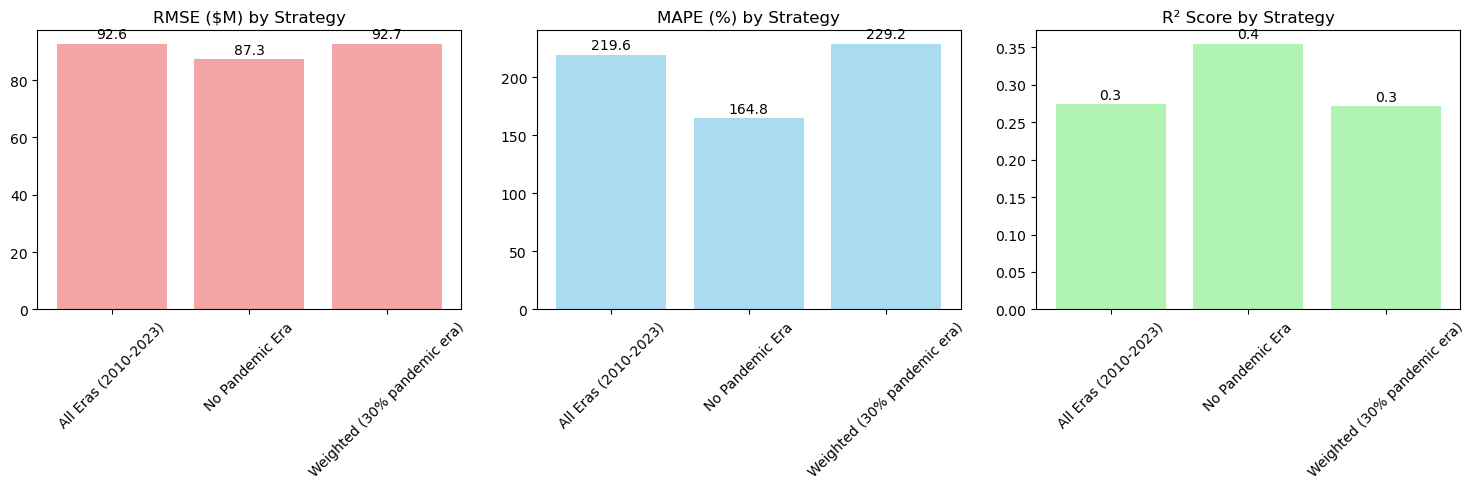

✅ Pandemic-aware model selection complete


In [12]:
# Compare strategies
print("\n📊 Strategy Comparison Results")
print("=" * 70)

strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in strategy_results
])

print(strategy_comparison.to_string(index=False))

# Find best strategy
best_strategy_idx = min(range(len(strategy_results)), key=lambda i: strategy_results[i]['rmse'])
best_strategy = strategy_results[best_strategy_idx]

print(f"\n🏆 Best Strategy: {best_strategy['strategy']}")
print(f"   Validation RMSE: ${best_strategy['rmse']:,.0f}")
print(f"   This will be used for 2026 predictions")

# Store best model
best_model_pandemic_aware = best_strategy['model_object']

# Visualize strategy comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['rmse', 'mape', 'r2']
metric_names = ['RMSE ($M)', 'MAPE (%)', 'R² Score']
colors = ['lightcoral', 'skyblue', 'lightgreen']

for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
    values = [r[metric] for r in strategy_results]
    strategies = [r['strategy'] for r in strategy_results]
    
    if metric == 'rmse':
        values = [v/1e6 for v in values]  # Convert to millions for readability
    
    bars = axes[i].bar(strategies, values, color=color, alpha=0.7)
    axes[i].set_title(f'{name} by Strategy')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("✅ Pandemic-aware model selection complete")

## 🌳 Approach 2: Decision Trees (Non-Linear Models)

**Why Decision Trees?**
- Captures non-linear relationships and feature interactions
- Naturally handles mixed data types and feature importance
- No assumption about data distribution
- Interpretable decision rules

**Experimental Design:**
- Same 3 pandemic strategies as Ridge (All Years, No Pandemic, Weighted)
- Hyperparameter tuning: max_depth, min_samples_split, min_samples_leaf, max_features
- Feature importance analysis to understand key predictors
- Compare against Ridge baseline

**Expected Outcome**: Test whether non-linear modeling improves over Ridge regression.

In [13]:
# Import Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

print("🌳 Setting up Decision Tree Regression Models")

def train_decision_tree_strategies(train_data, strategy_name, sample_weights=None):
    """Train Decision Tree models with a specific strategy"""
    print(f"🌳 Training Decision Tree - {strategy_name}")

    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    # Decision Tree pipeline (no scaling needed for trees)
    dt_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('dt', DecisionTreeRegressor(random_state=42))
    ])

    # Hyperparameter grid for Decision Tree
    dt_params = {
        'dt__max_depth': [5, 6, 7, 8, 9, 10],
        'dt__min_samples_split': [10, 20, 50],
        'dt__min_samples_leaf': [5, 10, 15],
        'dt__max_features': ['sqrt', 'log2', None]
    }

    dt_grid = GridSearchCV(
        dt_pipeline, dt_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )

    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights for Decision Trees
        # We'll use best params from unweighted search, then refit with weights
        dt_grid.fit(X_train_strat, y_train_strat_log)
        best_params = dt_grid.best_params_

        # Refit with weights
        dt_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('dt', DecisionTreeRegressor(
                max_depth=best_params['dt__max_depth'],
                min_samples_split=best_params['dt__min_samples_split'],
                min_samples_leaf=best_params['dt__min_samples_leaf'],
                max_features=best_params['dt__max_features'],
                random_state=42
            ))
        ])
        dt_weighted.fit(X_train_strat, y_train_strat_log, dt__sample_weight=sample_weights)
        dt_best = dt_weighted
        print(f"  Best params: {best_params}")
    else:
        dt_grid.fit(X_train_strat, y_train_strat_log)
        dt_best = dt_grid.best_estimator_
        best_params = dt_grid.best_params_
        print(f"  Best params: {best_params}")

    # Evaluate
    results = evaluate_model(dt_best, X_val, y_val_log, y_val, f"Decision Tree - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = dt_best
    results['model_type'] = 'Decision Tree'

    major_only_flag = None
    if 'is_major_studio' in train_data.columns:
        major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

    english_only_flag = None
    if 'original_language' in train_data.columns:
        english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

        extra_metrics = {}
    ranking_metrics = compute_ranking_metrics(
        val_data,
        results.get('predictions'),
        target_col=target,
        title_col='title',
        k=10,
    )
    if ranking_metrics:
        if 'top10_overlap' in ranking_metrics:
            results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
        for key, value in ranking_metrics.items():
            if key == 'top10_overlap':
                continue
            results[key] = value
        for key, value in ranking_metrics.items():
            if value is not None:
                extra_metrics[key] = float(value)

    if MLFLOW_AVAILABLE:
            tuned_params = {k.replace('dt__', ''): v for k, v in best_params.items()}
            params_to_log = {
                'model': 'DecisionTreeRegressor',
                'uses_sample_weights': sample_weights is not None,
                'n_features': len(feature_cols),
                'train_rows': len(train_data),
                'val_rows': len(val_data),
                **tuned_params,
            }
            tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='decision_tree')
            validation_snapshot = build_validation_snapshot(val_data, target)
            log_results_to_mlflow(
                results,
                run_name=f"DecisionTree | {strategy_name}",
                params=params_to_log,
                tags=tags,
                extra_metrics=extra_metrics or None,
                feature_frame=X_val,
                validation_frame=validation_snapshot,
                dataset_major_only=major_only_flag,
                dataset_english_only=english_only_flag,
                dataset_start_year=DATASET_START_YEAR,  # Added dataset start year
            )

    return results

print("✅ Decision Tree framework ready")

🌳 Setting up Decision Tree Regression Models
✅ Decision Tree framework ready


In [14]:
# Train Decision Tree models with all three strategies
dt_strategy_results = []

# Strategy 1: All eras including pandemic
dt_results_all = train_decision_tree_strategies(train_data_all, "All Eras (2010-2023)")
dt_strategy_results.append(dt_results_all)

# Strategy 2: Exclude pandemic era
dt_results_no_pandemic = train_decision_tree_strategies(train_data_no_pandemic, "No Pandemic Era")
dt_strategy_results.append(dt_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
dt_results_weighted = train_decision_tree_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
dt_strategy_results.append(dt_results_weighted)

🌳 Training Decision Tree - All Eras (2010-2023)
  Best params: {'dt__max_depth': 5, 'dt__max_features': None, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50}

Decision Tree - All Eras (2010-2023) Performance:
  RMSE: $84,370,577
  MAE:  $39,036,169
  MAPE: 182.5%
  R²:   0.397


2025/09/28 19:08:49 INFO mlflow.models.model: Found the following environment variables used during model inference: [TMDB_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


🌳 Training Decision Tree - No Pandemic Era
  Best params: {'dt__max_depth': 5, 'dt__max_features': None, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50}

Decision Tree - No Pandemic Era Performance:
  RMSE: $83,154,195
  MAE:  $38,459,133
  MAPE: 242.0%
  R²:   0.414
🌳 Training Decision Tree - Weighted (30% pandemic era)
  Best params: {'dt__max_depth': 5, 'dt__max_features': None, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50}

Decision Tree - Weighted (30% pandemic era) Performance:
  RMSE: $83,824,309
  MAE:  $38,797,948
  MAPE: 190.4%
  R²:   0.405


In [15]:
# Compare Decision Tree strategies
print("\n📊 Decision Tree Strategy Comparison")
print("=" * 70)

dt_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in dt_strategy_results
])

print(dt_strategy_comparison.to_string(index=False))

# Find best Decision Tree strategy
best_dt_strategy_idx = min(range(len(dt_strategy_results)), key=lambda i: dt_strategy_results[i]['rmse'])
best_dt_strategy = dt_strategy_results[best_dt_strategy_idx]

print(f"\n🏆 Best Decision Tree Strategy: {best_dt_strategy['strategy']}")
print(f"   Validation RMSE: ${best_dt_strategy['rmse']:,.0f}")

# Store best Decision Tree model
best_dt_model = best_dt_strategy['model_object']


📊 Decision Tree Strategy Comparison
                   Strategy        RMSE         MAE   MAPE    R²
       All Eras (2010-2023) $84,370,577 $39,036,169 182.5% 0.397
            No Pandemic Era $83,154,195 $38,459,133 242.0% 0.414
Weighted (30% pandemic era) $83,824,309 $38,797,948 190.4% 0.405

🏆 Best Decision Tree Strategy: No Pandemic Era
   Validation RMSE: $83,154,195



🔍 Feature Importance Analysis
Top 15 Most Important Features:
                    feature  importance
            is_major_studio    0.734212
                is_ip_movie    0.157168
     is_christmas_proximity    0.017437
        is_family_animation    0.016547
                  is_sequel    0.012862
                genre_drama    0.012125
                  is_disney    0.009069
              release_month    0.008996
nearby_major_releases_count    0.006853
              genre_fantasy    0.006368
             is_warner_bros    0.004794
        is_action_adventure    0.004596
             genre_thriller    0.004533
            genre_adventure    0.003078
       is_holiday_proximity    0.001363


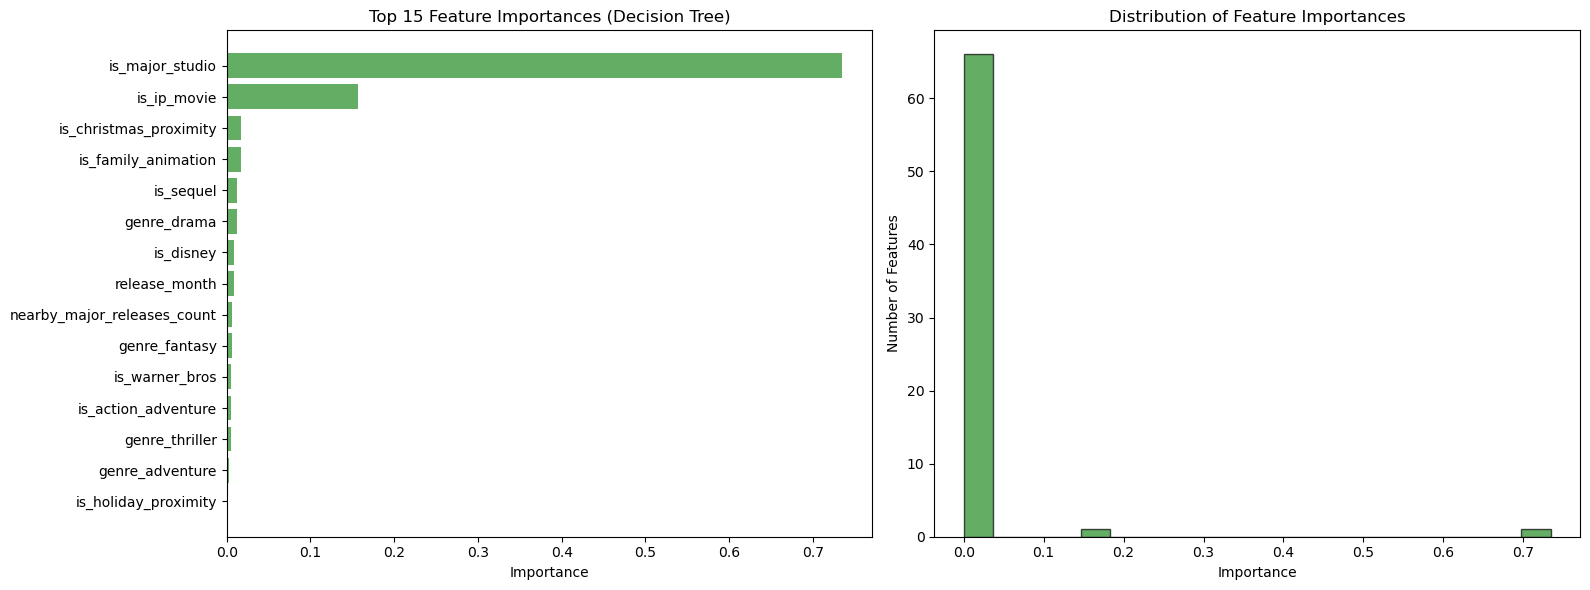


📈 Feature Analysis Summary:
   Total features: 68
   Features with importance > 0.01: 6
   Top 5 features account for: 93.8% of total importance


In [16]:
# Feature Importance Analysis (unique to Decision Trees)
print("\n🔍 Feature Importance Analysis")
print("=" * 50)

# Get feature importances from best Decision Tree model
dt_model = best_dt_model.named_steps['dt']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 most important features
top_features = feature_importance.head(15)
print("Top 15 Most Important Features:")
print(top_features.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 features
axes[0].barh(top_features['feature'][::-1], top_features['importance'][::-1], color='forestgreen', alpha=0.7)
axes[0].set_title('Top 15 Feature Importances (Decision Tree)')
axes[0].set_xlabel('Importance')

# Feature importance distribution
axes[1].hist(feature_importance['importance'], bins=20, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Number of Features')

plt.tight_layout()
plt.show()

print(f"\n📈 Feature Analysis Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features with importance > 0.01: {(feature_importance['importance'] > 0.01).sum()}")
print(f"   Top 5 features account for: {top_features['importance'].head(5).sum():.1%} of total importance")

## 🌲 Approach 3: Random Forest (Ensemble Models)

**Why Random Forest?**
- Ensemble of decision trees reduces overfitting
- Better generalization than single decision trees
- Built-in feature importance and variance reduction
- Robust to outliers and noise

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Extensive hyperparameter tuning: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
- Feature importance analysis and comparison with Decision Tree
- Bootstrap aggregation for improved stability

**Expected Outcome**: Test whether ensemble methods provide the best performance for box office prediction.

In [17]:
# Import Random Forest
from sklearn.ensemble import RandomForestRegressor

print("🌲 Setting up Random Forest Regression Models")

def train_random_forest_strategies(train_data, strategy_name, sample_weights=None):
    """Train Random Forest models with a specific strategy"""
    print(f"🌲 Training Random Forest - {strategy_name}")

    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    # Random Forest pipeline (no scaling needed for tree-based models)
    rf_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])

    # Hyperparameter grid for Random Forest
    rf_params = {
        'rf__n_estimators': [100, 150, 200],  # Start with 100 as requested
        'rf__max_depth': [6, 8, 10, 12, None],
        'rf__min_samples_split': [10, 20, 50],
        'rf__min_samples_leaf': [5, 10, 15],
        'rf__max_features': ['sqrt', 'log2', 0.3]
    }

    rf_grid = GridSearchCV(
        rf_pipeline, rf_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )

    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights for Random Forest
        # We'll use best params from unweighted search, then refit with weights
        print("  Running hyperparameter search...")
        rf_grid.fit(X_train_strat, y_train_strat_log)
        best_params = rf_grid.best_params_

        # Refit with weights
        print("  Refitting with sample weights...")
        rf_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('rf', RandomForestRegressor(
                n_estimators=best_params['rf__n_estimators'],
                max_depth=best_params['rf__max_depth'],
                min_samples_split=best_params['rf__min_samples_split'],
                min_samples_leaf=best_params['rf__min_samples_leaf'],
                max_features=best_params['rf__max_features'],
                random_state=42,
                n_jobs=-1
            ))
        ])
        rf_weighted.fit(X_train_strat, y_train_strat_log, rf__sample_weight=sample_weights)
        rf_best = rf_weighted
        print(f"  Best params: {best_params}")
    else:
        print("  Running hyperparameter search...")
        rf_grid.fit(X_train_strat, y_train_strat_log)
        rf_best = rf_grid.best_estimator_
        best_params = rf_grid.best_params_
        print(f"  Best params: {best_params}")

    # Evaluate
    results = evaluate_model(rf_best, X_val, y_val_log, y_val, f"Random Forest - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = rf_best
    results['model_type'] = 'Random Forest'

    major_only_flag = None
    if 'is_major_studio' in train_data.columns:
        major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

    english_only_flag = None
    if 'original_language' in train_data.columns:
        english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

        extra_metrics = {}
    ranking_metrics = compute_ranking_metrics(
        val_data,
        results.get('predictions'),
        target_col=target,
        title_col='title',
        k=10,
    )
    if ranking_metrics:
        if 'top10_overlap' in ranking_metrics:
            results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
        for key, value in ranking_metrics.items():
            if key == 'top10_overlap':
                continue
            results[key] = value
        for key, value in ranking_metrics.items():
            if value is not None:
                extra_metrics[key] = float(value)

    if MLFLOW_AVAILABLE:
            tuned_params = {k.replace('rf__', ''): v for k, v in best_params.items()}
            params_to_log = {
                'model': 'RandomForestRegressor',
                'uses_sample_weights': sample_weights is not None,
                'n_features': len(feature_cols),
                'train_rows': len(train_data),
                'val_rows': len(val_data),
                **tuned_params,
            }
            tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='random_forest')
            validation_snapshot = build_validation_snapshot(val_data, target)
            log_results_to_mlflow(
                results,
                run_name=f"RandomForest | {strategy_name}",
                params=params_to_log,
                tags=tags,
                extra_metrics=extra_metrics or None,
                feature_frame=X_val,
                validation_frame=validation_snapshot,
                dataset_major_only=major_only_flag,
                dataset_english_only=english_only_flag,
                dataset_start_year=DATASET_START_YEAR,  # Added dataset start year
            )

    return results

print("✅ Random Forest framework ready")

🌲 Setting up Random Forest Regression Models
✅ Random Forest framework ready


In [18]:
# Train Random Forest models with all three strategies 
print("🎯 Training Random Forest Models")

rf_strategy_results = []

# Strategy 1: All eras including pandemic
rf_results_all = train_random_forest_strategies(train_data_all, "All Eras (2010-2023)")
rf_strategy_results.append(rf_results_all)

# Strategy 2: Exclude pandemic era
rf_results_no_pandemic = train_random_forest_strategies(train_data_no_pandemic, "No Pandemic Era")
rf_strategy_results.append(rf_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
rf_results_weighted = train_random_forest_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
rf_strategy_results.append(rf_results_weighted)

🎯 Training Random Forest Models
🌲 Training Random Forest - All Eras (2010-2023)
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  Best params: {'rf__max_depth': 6, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}

Random Forest - All Eras (2010-2023) Performance:
  RMSE: $90,618,629
  MAE:  $39,333,898
  MAPE: 190.4%
  R²:   0.305
🌲 Training Random Forest - No Pandemic Era
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  Best params: {'rf__max_depth': 10, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 50, 'rf__n_estimators': 200}

Random Forest - No Pandemic Era Performance:
  RMSE: $91,464,890
  MAE:  $40,032,936
  MAPE: 207.6%
  R²:   0.292
🌲 Training Random Forest - Weighted (30% pandemic era)
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  Re

In [19]:
# Compare Random Forest strategies
print("\n📊 Random Forest Strategy Comparison")
print("=" * 70)

rf_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in rf_strategy_results
])

print(rf_strategy_comparison.to_string(index=False))

# Find best Random Forest strategy
best_rf_strategy_idx = min(range(len(rf_strategy_results)), key=lambda i: rf_strategy_results[i]['rmse'])
best_rf_strategy = rf_strategy_results[best_rf_strategy_idx]

print(f"\n🏆 Best Random Forest Strategy: {best_rf_strategy['strategy']}")
print(f"   Validation RMSE: ${best_rf_strategy['rmse']:,.0f}")

# Store best Random Forest model
best_rf_model = best_rf_strategy['model_object']


📊 Random Forest Strategy Comparison
                   Strategy        RMSE         MAE   MAPE    R²
       All Eras (2010-2023) $90,618,629 $39,333,898 190.4% 0.305
            No Pandemic Era $91,464,890 $40,032,936 207.6% 0.292
Weighted (30% pandemic era) $88,604,975 $38,993,078 195.6% 0.335

🏆 Best Random Forest Strategy: Weighted (30% pandemic era)
   Validation RMSE: $88,604,975



🔍 Random Forest Feature Importance Analysis
Top 15 Most Important Features (Random Forest):
                    feature  importance
            is_major_studio    0.432007
                is_ip_movie    0.161886
                  is_sequel    0.051111
                genre_drama    0.048938
            genre_adventure    0.048505
                  is_disney    0.022826
             is_warner_bros    0.014168
              release_month    0.014062
               is_superhero    0.013975
        is_action_adventure    0.013048
       years_since_baseline    0.011954
               is_universal    0.011019
                genre_count    0.010405
            days_to_holiday    0.010398
nearby_major_releases_count    0.010120


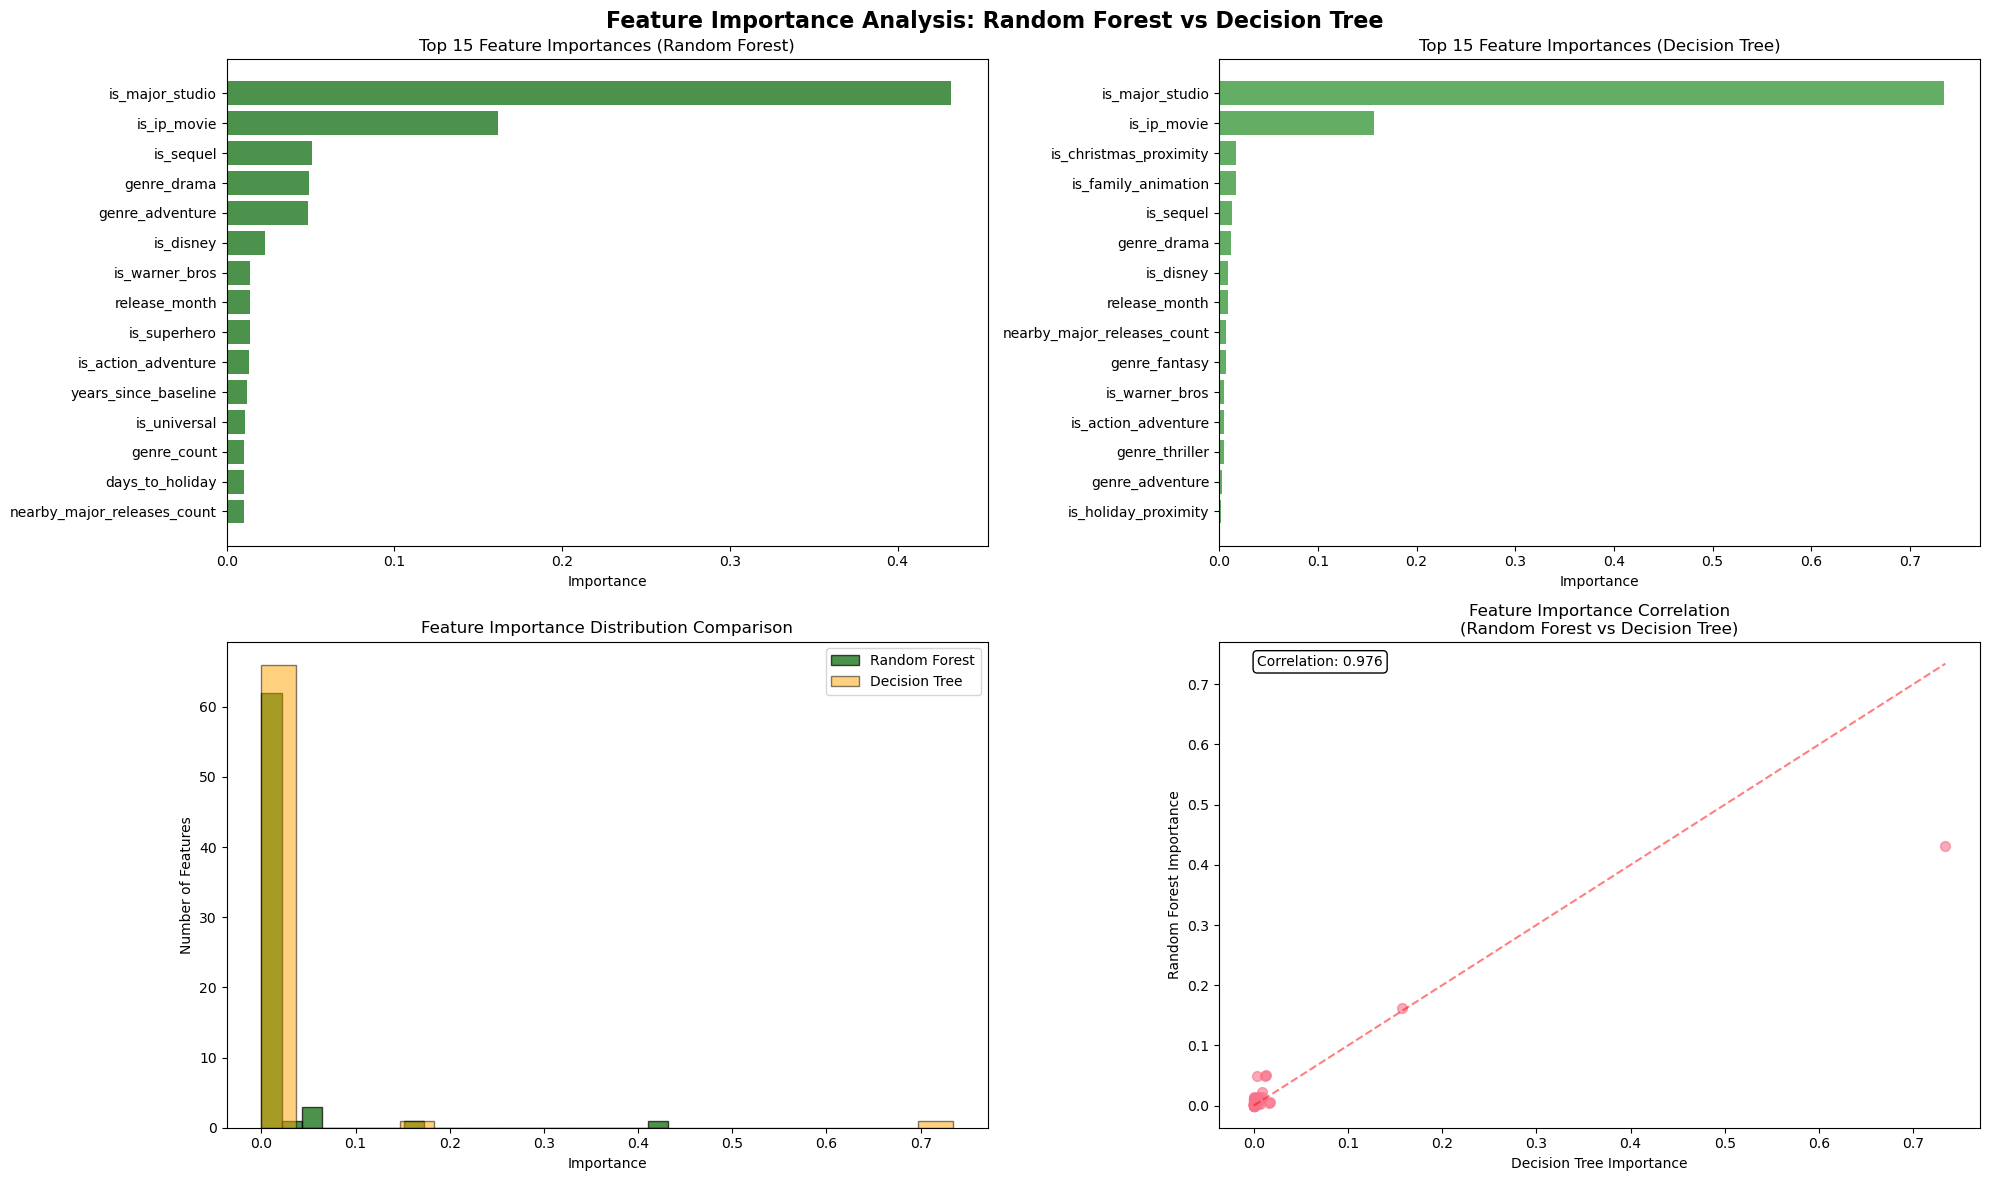


📈 Random Forest Feature Analysis Summary:
   Total features: 68
   Features with importance > 0.01: 15
   Top 5 features account for: 74.2% of total importance
   RF vs DT feature importance correlation: 0.976

🔄 Feature Ranking Differences (RF vs DT):
Top 10 features with largest ranking differences:
             feature  rf_rank  dt_rank  rank_diff
years_since_baseline       10       63         53
        is_superhero        8       60         52
  is_origin_us_uk_ca       63       16         47
          is_english       65       22         43
is_remake_adaptation       19       62         43
     days_to_holiday       13       50         37
       genre_fantasy       40        9         31
       genre_mystery       60       29         31
is_holiday_proximity       43       14         29
is_pre_streaming_era       35       64         29


In [20]:
# Random Forest Feature Importance Analysis
print("\n🔍 Random Forest Feature Importance Analysis")
print("=" * 60)

# Get feature importances from best Random Forest model
rf_model = best_rf_model.named_steps['rf']
rf_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 most important features
rf_top_features = rf_feature_importance.head(15)
print("Top 15 Most Important Features (Random Forest):")
print(rf_top_features.to_string(index=False))

# Compare with Decision Tree feature importance
dt_model = best_dt_model.named_steps['dt']
dt_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Feature Importance Analysis: Random Forest vs Decision Tree', fontsize=16, fontweight='bold')

# Top 15 Random Forest features
axes[0,0].barh(rf_top_features['feature'][::-1], rf_top_features['importance'][::-1], 
               color='darkgreen', alpha=0.7)
axes[0,0].set_title('Top 15 Feature Importances (Random Forest)')
axes[0,0].set_xlabel('Importance')

# Top 15 Decision Tree features (for comparison)
dt_top_features = dt_feature_importance.head(15)
axes[0,1].barh(dt_top_features['feature'][::-1], dt_top_features['importance'][::-1], 
               color='forestgreen', alpha=0.7)
axes[0,1].set_title('Top 15 Feature Importances (Decision Tree)')
axes[0,1].set_xlabel('Importance')

# Feature importance distribution comparison
axes[1,0].hist(rf_feature_importance['importance'], bins=20, alpha=0.7, 
               color='darkgreen', label='Random Forest', edgecolor='black')
axes[1,0].hist(dt_feature_importance['importance'], bins=20, alpha=0.5, 
               color='orange', label='Decision Tree', edgecolor='black')
axes[1,0].set_title('Feature Importance Distribution Comparison')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Number of Features')
axes[1,0].legend()

# Feature importance correlation between models
# Create merged dataframe for comparison
importance_comparison = pd.merge(
    rf_feature_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    dt_feature_importance[['feature', 'importance']].rename(columns={'importance': 'dt_importance'}),
    on='feature'
)

axes[1,1].scatter(importance_comparison['dt_importance'], importance_comparison['rf_importance'], 
                 alpha=0.6, s=50)
axes[1,1].set_xlabel('Decision Tree Importance')
axes[1,1].set_ylabel('Random Forest Importance')
axes[1,1].set_title('Feature Importance Correlation\n(Random Forest vs Decision Tree)')

# Add diagonal line
max_importance = max(importance_comparison['dt_importance'].max(), 
                    importance_comparison['rf_importance'].max())
axes[1,1].plot([0, max_importance], [0, max_importance], 'r--', alpha=0.5)

# Calculate correlation
correlation = importance_comparison['dt_importance'].corr(importance_comparison['rf_importance'])
axes[1,1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
               transform=axes[1,1].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

plt.tight_layout()
plt.show()

print(f"\n📈 Random Forest Feature Analysis Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features with importance > 0.01: {(rf_feature_importance['importance'] > 0.01).sum()}")
print(f"   Top 5 features account for: {rf_top_features['importance'].head(5).sum():.1%} of total importance")
print(f"   RF vs DT feature importance correlation: {correlation:.3f}")

# Show top features that differ between models
print(f"\n🔄 Feature Ranking Differences (RF vs DT):")
rf_ranks = {feat: i for i, feat in enumerate(rf_feature_importance['feature'])}
dt_ranks = {feat: i for i, feat in enumerate(dt_feature_importance['feature'])}

rank_differences = []
for feat in feature_cols:
    rf_rank = rf_ranks[feat]
    dt_rank = dt_ranks[feat]
    rank_diff = abs(rf_rank - dt_rank)
    rank_differences.append({'feature': feat, 'rf_rank': rf_rank, 'dt_rank': dt_rank, 'rank_diff': rank_diff})

rank_differences = pd.DataFrame(rank_differences).sort_values('rank_diff', ascending=False)
print("Top 10 features with largest ranking differences:")
print(rank_differences.head(10)[['feature', 'rf_rank', 'dt_rank', 'rank_diff']].to_string(index=False))

## 🚀 Approach 4: XGBoost (Gradient Boosting)

**Why XGBoost?**
- State-of-the-art gradient boosting framework
- Excellent performance on structured/tabular data
- Built-in regularization and feature importance
- Handles missing values automatically
- Often wins machine learning competitions

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Extensive hyperparameter tuning: n_estimators, max_depth, learning_rate, subsample, colsample_bytree
- Feature importance analysis and comparison with tree-based models
- Built-in cross-validation for early stopping

**Expected Outcome**: Test whether gradient boosting provides superior performance for box office prediction.

In [21]:
print("🚀 Setting up XGBoost Regression Models")

def train_xgboost_strategies(train_data, strategy_name, sample_weights=None):
    """Train XGBoost models with a specific strategy"""
    print(f"🚀 Training XGBoost - {strategy_name}")

    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    # XGBoost pipeline
    xgb_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('xgb', xgb.XGBRegressor(random_state=42, verbosity=0))
    ])

    # Hyperparameter grid
    xgb_params = {
        'xgb__n_estimators': [100, 200, 300],
        'xgb__max_depth': [3, 4, 5, 6],
        'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'xgb__subsample': [0.8, 0.9, 1.0],
        'xgb__colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_grid = GridSearchCV(
        xgb_pipeline, xgb_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )

    # Fit with or without sample weights
    if sample_weights is not None:
        print("  Running hyperparameter search...")
        xgb_grid.fit(X_train_strat, y_train_strat_log)
        best_params = xgb_grid.best_params_

        print("  Refitting with sample weights...")
        xgb_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('xgb', xgb.XGBRegressor(
                n_estimators=best_params['xgb__n_estimators'],
                max_depth=best_params['xgb__max_depth'],
                learning_rate=best_params['xgb__learning_rate'],
                subsample=best_params['xgb__subsample'],
                colsample_bytree=best_params['xgb__colsample_bytree'],
                random_state=42,
                verbosity=0
            ))
        ])
        xgb_weighted.fit(X_train_strat, y_train_strat_log, xgb__sample_weight=sample_weights)
        xgb_best = xgb_weighted
        print(f"  Best params: {best_params}")
    else:
        print("  Running hyperparameter search...")
        xgb_grid.fit(X_train_strat, y_train_strat_log)
        xgb_best = xgb_grid.best_estimator_
        best_params = xgb_grid.best_params_
        print(f"  Best params: {best_params}")

    # Evaluate
    results = evaluate_model(xgb_best, X_val, y_val_log, y_val, f"XGBoost - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = xgb_best
    results['model_type'] = 'XGBoost'

    major_only_flag = None
    if 'is_major_studio' in train_data.columns:
        major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

    english_only_flag = None
    if 'original_language' in train_data.columns:
        english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

    extra_metrics = {}
    ranking_metrics = compute_ranking_metrics(
        val_data,
        results.get('predictions'),
        target_col=target,
        title_col='title',
        k=10,
    )
    if ranking_metrics:
        if 'top10_overlap' in ranking_metrics:
            results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
        for key, value in ranking_metrics.items():
            if key == 'top10_overlap':
                continue
            results[key] = value
        for key, value in ranking_metrics.items():
            if value is not None:
                extra_metrics[key] = float(value)

    if MLFLOW_AVAILABLE:
        tuned_params = {k.replace('xgb__', ''): v for k, v in best_params.items()}
        params_to_log = {
            'model': 'XGBRegressor',
            'uses_sample_weights': sample_weights is not None,
            'n_features': len(feature_cols),
            'train_rows': len(train_data),
            'val_rows': len(val_data),
            **tuned_params,
        }
        tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='xgboost')
        validation_snapshot = build_validation_snapshot(val_data, target)
        log_results_to_mlflow(
            results,
            run_name=f"XGBoost | {strategy_name}",
            params=params_to_log,
            tags=tags,
            extra_metrics=extra_metrics or None,
            feature_frame=X_val,
            validation_frame=validation_snapshot,
            dataset_major_only=major_only_flag,
            dataset_english_only=english_only_flag,
            dataset_start_year=DATASET_START_YEAR,  # Added dataset start year
        )

    return results  # ✅ correctly indented inside the function

print("✅ XGBoost framework ready")

🚀 Setting up XGBoost Regression Models
✅ XGBoost framework ready


In [22]:
# Train XGBoost models with all three strategies 
print("🎯 Training XGBoost Models")

xgb_strategy_results = []

# Strategy 1: All eras including pandemic
xgb_results_all = train_xgboost_strategies(train_data_all, "All Eras (2010-2023)")
xgb_strategy_results.append(xgb_results_all)

# Strategy 2: Exclude pandemic era
xgb_results_no_pandemic = train_xgboost_strategies(train_data_no_pandemic, "No Pandemic Era")
xgb_strategy_results.append(xgb_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
xgb_results_weighted = train_xgboost_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
xgb_strategy_results.append(xgb_results_weighted)

# Compare XGBoost strategies
print("\n📊 XGBoost Strategy Comparison")
print("=" * 70)

xgb_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in xgb_strategy_results
])

print(xgb_strategy_comparison.to_string(index=False))

# Find best XGBoost strategy
best_xgb_strategy_idx = min(range(len(xgb_strategy_results)), key=lambda i: xgb_strategy_results[i]['rmse'])
best_xgb_strategy = xgb_strategy_results[best_xgb_strategy_idx]

print(f"\n🏆 Best XGBoost Strategy: {best_xgb_strategy['strategy']}")
print(f"   Validation RMSE: ${best_xgb_strategy['rmse']:,.0f}")

# Store best XGBoost model
best_xgb_model = best_xgb_strategy['model_object']

xgb_strategy_results = []

🎯 Training XGBoost Models
🚀 Training XGBoost - All Eras (2010-2023)
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Best params: {'xgb__colsample_bytree': 0.9, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}

XGBoost - All Eras (2010-2023) Performance:
  RMSE: $92,629,632
  MAE:  $39,768,405
  MAPE: 196.0%
  R²:   0.273
🚀 Training XGBoost - No Pandemic Era
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}

XGBoost - No Pandemic Era Performance:
  RMSE: $90,848,920
  MAE:  $39,362,826
  MAPE: 215.4%
  R²:   0.301
🚀 Training XGBoost - Weighted (30% pandemic era)
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Refitting with sample weights...
  B

## 💡 Approach 5: LightGBM (Fast Gradient Boosting)

**Why LightGBM?**
- Microsoft's high-performance gradient boosting framework
- Faster training than XGBoost with similar accuracy
- Built-in categorical feature handling
- Memory efficient and scalable
- Often comparable or superior to XGBoost

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Hyperparameter tuning: n_estimators, max_depth, learning_rate, num_leaves, feature_fraction
- Feature importance analysis and comparison with other tree-based models
- Early stopping to prevent overfitting

**Expected Outcome**: Compare LightGBM performance against XGBoost and other models.

In [23]:
# ============================================
# LightGBM: RandomizedSearchCV + Early Stopping
# ============================================

print("💡 Setting up LightGBM Regression Models (RandomizedSearchCV)")

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

LGB_N_ITER = 40
LGB_CV_FOLDS = 5
LGB_ES_ROUNDS = 100
LGB_RANDOM_STATE = 42

def train_lightgbm_strategies(train_data, strategy_name, sample_weights=None):
    """Train LightGBM models with a specific strategy (RandomizedSearchCV)"""
    print(f"💡 Training LightGBM - {strategy_name}")

    # Split
    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    # Pipeline
    lgb_pipeline = Pipeline([
        ('lgb', lgb.LGBMRegressor(
            random_state=LGB_RANDOM_STATE,
            verbosity=-1,
            n_jobs=1
        ))
    ])

    # Search space
    lgb_param_dist = {
        'lgb__n_estimators': [500, 1000, 1500, 2000],
        'lgb__learning_rate': [0.02, 0.03, 0.05, 0.08],
        'lgb__num_leaves': [63, 95, 127, 191],
        'lgb__min_child_samples': [20, 50, 100, 200],
        'lgb__max_depth': [-1],
        'lgb__feature_fraction': [0.7, 0.8, 0.9, 1.0],
        'lgb__bagging_fraction': [0.7, 0.8, 0.9, 1.0],
        'lgb__bagging_freq': [1],
        'lgb__reg_lambda': [0.0, 1.0, 5.0, 10.0],
        'lgb__reg_alpha': [0.0, 0.1, 0.5, 1.0],
        'lgb__min_split_gain': [0.0, 0.05, 0.1]
    }

    lgb_rand = RandomizedSearchCV(
        estimator=lgb_pipeline,
        param_distributions=lgb_param_dist,
        n_iter=LGB_N_ITER,
        cv=LGB_CV_FOLDS,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=LGB_RANDOM_STATE
    )

    # Early stopping
    es_cb = lgb.early_stopping(stopping_rounds=LGB_ES_ROUNDS, verbose=False)
    fit_kwargs = {
        'lgb__eval_set': [(X_val, y_val_log)],
        'lgb__eval_metric': 'rmse',
        'lgb__callbacks': [es_cb]
    }

    print("  Running randomized search...")
    if sample_weights is None:
        lgb_rand.fit(X_train_strat, y_train_strat_log, **fit_kwargs)
        lgb_best = lgb_rand.best_estimator_
        best_params = lgb_rand.best_params_
        print(f"  Best params: {best_params}")
    else:
        lgb_rand.fit(X_train_strat, y_train_strat_log, **fit_kwargs)
        best_params = lgb_rand.best_params_
        print(f"  Best params: {best_params}")

        print("  Refitting with sample weights...")
        lgb_weighted = Pipeline([
            ('lgb', lgb.LGBMRegressor(
                n_estimators=best_params['lgb__n_estimators'],
                learning_rate=best_params['lgb__learning_rate'],
                num_leaves=best_params['lgb__num_leaves'],
                min_child_samples=best_params['lgb__min_child_samples'],
                max_depth=best_params['lgb__max_depth'],
                feature_fraction=best_params['lgb__feature_fraction'],
                bagging_fraction=best_params['lgb__bagging_fraction'],
                bagging_freq=best_params['lgb__bagging_freq'],
                reg_lambda=best_params['lgb__reg_lambda'],
                reg_alpha=best_params['lgb__reg_alpha'],
                min_split_gain=best_params['lgb__min_split_gain'],
                random_state=LGB_RANDOM_STATE,
                verbosity=-1,
                n_jobs=1
            ))
        ])
        lgb_weighted.fit(
            X_train_strat, y_train_strat_log,
            lgb__sample_weight=sample_weights,
            **fit_kwargs
        )
        lgb_best = lgb_weighted

    # Evaluate
    results = evaluate_model(lgb_best, X_val, y_val_log, y_val, f"LightGBM - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = lgb_best
    results['model_type'] = 'LightGBM'

    major_only_flag = None
    if 'is_major_studio' in train_data.columns:
        major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

    english_only_flag = None
    if 'original_language' in train_data.columns:
        english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

    extra_metrics = {}
    ranking_metrics = compute_ranking_metrics(
        val_data,
        results.get('predictions'),
        target_col=target,
        title_col='title',
        k=10,
    )
    if ranking_metrics:
        if 'top10_overlap' in ranking_metrics:
            results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
        for key, value in ranking_metrics.items():
            if key == 'top10_overlap':
                continue
            results[key] = value
        for key, value in ranking_metrics.items():
            if value is not None:
                extra_metrics[key] = float(value)

    if MLFLOW_AVAILABLE:
        tuned_params = {k.replace('lgb__', ''): v for k, v in best_params.items()}
        params_to_log = {
            'model': 'LGBMRegressor',
            'uses_sample_weights': sample_weights is not None,
            'n_features': len(feature_cols),
            'train_rows': len(train_data),
            'val_rows': len(val_data),
            **tuned_params,
        }
        tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='lightgbm')
        validation_snapshot = build_validation_snapshot(val_data, target)
        log_results_to_mlflow(
            results,
            run_name=f"LightGBM | {strategy_name}",
            params=params_to_log,
            tags=tags,
            extra_metrics=extra_metrics or None,
            feature_frame=X_val,
            validation_frame=validation_snapshot,
            dataset_major_only=major_only_flag,
            dataset_english_only=english_only_flag,
            dataset_start_year=DATASET_START_YEAR,  # Added dataset start year
        )

    return results  # ✅ correctly indented inside the function

print("✅ LightGBM (Randomized) framework ready")

💡 Setting up LightGBM Regression Models (RandomizedSearchCV)
✅ LightGBM (Randomized) framework ready


In [24]:
# =========================
# Run the LightGBM strategies
# =========================
print("🎯 Training LightGBM Models (RandomizedSearchCV)")

lgb_strategy_results = []

# Strategy 1: All eras including pandemic
lgb_results_all = train_lightgbm_strategies(train_data_all, "All Eras (2010-2023)")
lgb_strategy_results.append(lgb_results_all)

# Strategy 2: Exclude pandemic era
lgb_results_no_pandemic = train_lightgbm_strategies(train_data_no_pandemic, "No Pandemic Era")
lgb_strategy_results.append(lgb_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
lgb_results_weighted = train_lightgbm_strategies(
    train_data_weighted,
    "Weighted (30% pandemic era)",
    sample_weights
)
lgb_strategy_results.append(lgb_results_weighted)

# Compare strategies
print("\n📊 LightGBM Strategy Comparison")
print("=" * 70)
lgb_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in lgb_strategy_results
])
print(lgb_strategy_comparison.to_string(index=False))

# Pick best
best_lgb_strategy_idx = min(
    range(len(lgb_strategy_results)),
    key=lambda i: lgb_strategy_results[i]['rmse']
)
best_lgb_strategy = lgb_strategy_results[best_lgb_strategy_idx]

print(f"\n🏆 Best LightGBM Strategy: {best_lgb_strategy['strategy']}")
print(f"   Validation RMSE: ${best_lgb_strategy['rmse']:,.0f}")

# Store best model
best_lgb_model = best_lgb_strategy['model_object']

lgb_strategy_results = []

🎯 Training LightGBM Models (RandomizedSearchCV)
💡 Training LightGBM - All Eras (2010-2023)
  Running randomized search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
  Best params: {'lgb__reg_lambda': 10.0, 'lgb__reg_alpha': 1.0, 'lgb__num_leaves': 191, 'lgb__n_estimators': 2000, 'lgb__min_split_gain': 0.05, 'lgb__min_child_samples': 100, 'lgb__max_depth': -1, 'lgb__learning_rate': 0.02, 'lgb__feature_fraction': 0.7, 'lgb__bagging_freq': 1, 'lgb__bagging_fraction': 1.0}

LightGBM - All Eras (2010-2023) Performance:
  RMSE: $85,427,938
  MAE:  $36,721,230
  MAPE: 169.6%
  R²:   0.382
💡 Training LightGBM - No Pandemic Era
  Running randomized search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
  Best params: {'lgb__reg_lambda': 1.0, 'lgb__reg_alpha': 1.0, 'lgb__num_leaves': 191, 'lgb__n_estimators': 1500, 'lgb__min_split_gain': 0.0, 'lgb__min_child_samples': 50, 'lgb__max_depth': -1, 'lgb__learning_rate': 0.05, 'lgb__feature_fraction': 0.9, 'lgb__bag

In [25]:
# Save best models from each approach for comparison in notebook 5
import pickle
import os

print("💾 Saving Best Models for Final Comparison")
print("=" * 60)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Collect all available results
all_available_results = []

# Find best Ridge model
best_ridge_idx = min(range(len(strategy_results)), key=lambda i: strategy_results[i]['rmse'])
best_ridge = strategy_results[best_ridge_idx]
all_available_results.append(('ridge', best_ridge))

# Find best Decision Tree model  
best_dt_idx = min(range(len(dt_strategy_results)), key=lambda i: dt_strategy_results[i]['rmse'])
best_dt = dt_strategy_results[best_dt_idx]
all_available_results.append(('decision_tree', best_dt))

# Find best Random Forest model
best_rf_idx = min(range(len(rf_strategy_results)), key=lambda i: rf_strategy_results[i]['rmse'])
best_rf = rf_strategy_results[best_rf_idx]
all_available_results.append(('random_forest', best_rf))

# Find best XGBoost model
if len(xgb_strategy_results) > 0:
    best_xgb_idx = min(range(len(xgb_strategy_results)), key=lambda i: xgb_strategy_results[i]['rmse'])
    best_xgb = xgb_strategy_results[best_xgb_idx]
    all_available_results.append(('xgboost', best_xgb))

# Find best LightGBM model
if len(lgb_strategy_results) > 0:
    best_lgb_idx = min(range(len(lgb_strategy_results)), key=lambda i: lgb_strategy_results[i]['rmse'])
    best_lgb = lgb_strategy_results[best_lgb_idx]
    all_available_results.append(('lightgbm', best_lgb))

# Save best models and their metadata
models_to_save = {}
for model_name, best_result in all_available_results:
    models_to_save[model_name] = {
        'model': best_result['model_object'],
        'strategy': best_result['strategy'],
        'rmse': best_result['rmse'],
        'mae': best_result['mae'],
        'mape': best_result['mape'],
        'r2': best_result['r2'],
        'type': best_result.get('model_type', model_name.replace('_', ' ').title())
    }

# Save each model
for model_name, model_data in models_to_save.items():
    with open(f'../models/best_{model_name}_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"✅ Saved {model_data['type']} ({model_data['strategy']})")
    print(f"   RMSE: ${model_data['rmse']:,.0f}, R²: {model_data['r2']:.3f}")

# Save feature columns for consistency
with open('../models/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print(f"\n📁 Models saved to ../models/ directory")
saved_models = [f"best_{name}_model.pkl" for name in models_to_save.keys()]
for model_file in saved_models:
    print(f"   • {model_file}")
print(f"   • feature_columns.pkl")

print(f"\n🔄 Use these models in notebook 5 for final comparison")
print(f"📊 Total models available: {len(models_to_save)}")

# Show quick comparison of all models
if len(models_to_save) > 1:
    print(f"\n🏆 Quick Model Comparison (Best RMSE):")
    comparison_list = [(name, data['rmse'], data['r2']) for name, data in models_to_save.items()]
    comparison_list.sort(key=lambda x: x[1])  # Sort by RMSE
    
    for i, (name, rmse, r2) in enumerate(comparison_list, 1):
        print(f"   {i}. {name.replace('_', ' ').title()}: RMSE ${rmse:,.0f}, R² {r2:.3f}")
    
    best_overall = comparison_list[0]
    print(f"\n🥇 Overall Best: {best_overall[0].replace('_', ' ').title()}")
    print(f"   RMSE: ${best_overall[1]:,.0f}")
    print(f"   R²: {best_overall[2]:.3f}")

💾 Saving Best Models for Final Comparison
✅ Saved Ridge (No Pandemic Era)
   RMSE: $87,271,535, R²: 0.355
✅ Saved Decision Tree (No Pandemic Era)
   RMSE: $83,154,195, R²: 0.414
✅ Saved Random Forest (Weighted (30% pandemic era))
   RMSE: $88,604,975, R²: 0.335

📁 Models saved to ../models/ directory
   • best_ridge_model.pkl
   • best_decision_tree_model.pkl
   • best_random_forest_model.pkl
   • feature_columns.pkl

🔄 Use these models in notebook 5 for final comparison
📊 Total models available: 3

🏆 Quick Model Comparison (Best RMSE):
   1. Decision Tree: RMSE $83,154,195, R² 0.414
   2. Ridge: RMSE $87,271,535, R² 0.355
   3. Random Forest: RMSE $88,604,975, R² 0.335

🥇 Overall Best: Decision Tree
   RMSE: $83,154,195
   R²: 0.414
